# Preamble

In [28]:
# Imports
## General
import numpy as np

## Data manipulation and preprocessing
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Data Download - Preferred, fully replicable to the below

As an alternative to the above, one can also run `dvc pull` in the CLI. See documentation for [DVC](https://dvc.org/doc/command-reference/pull) for reference. This depends on installing `dvc` and `s3fs` in the environment.

### Data Download - Alternative

Run the following line once in order to retrieve the data samples from AWS S3. Below, we pass 100000 as the sample argument. Before doing so, please ensure that `boto3` and `s3fs` are installed. Refer to `requirements.txt` for further dependencies.
```{python}
%run scripts/s3_data_retrieval/retrieve_samples_from_s3.py 100000
```

# Introduction

The global digital advertising market is worth approximately $602 billion today. Due to the increasing rate of of online participation since the COVID-19 pandemic, this number has been rapidly increasing and is expected to reach $871 billion by the end of 2027 ([eMarketer, 2024](#eMarketer)). Many of the of the major Ad platforms such as Google, Facebook and Amazon operate on a cost-per-user-engagement pricing model, which usually means that advertisers get charged for every time a user clicks on an advertisment. This means that these platforms are incentivized to make sure that the content shown to each user is as relevent as possible in order to maximize the number of clicks in the long term. Attaining accurate Click-Through Rate (CTR) prediction is a necessary first step for Ad persionalization, which is why study of CTR prediction methods have been an extremely active part of Machine Learning research over the past through years.

Initially, shallow prediction methods such as XGBoost (Cite), Factorization Machines (Cite) and Field-Aware Factorization Machines (Cite) have been used for CTR prediction. However, these methods have often been shown to be unable to capture the higher order feature interactions in the sparse multy value categorical Ad Marketplace datasets (Cite). Since then, Deep Learning methods have been shown to show superior predictive ability on these datasets. The focus of my reasearch project is therefore to explore the merits of different Deep Learning architechtures for click-through rate prediction

In the following report, I explore the relevant datasets and simulations that I will be using throughout my research project. In the first section, I perform an exploratory data analysis on three widely adopted benchmark CTR prediction datasets; the KDD12 ([Aden, 2012](#kdd12)), Avazu ([Wang and Cukierski, 2014](#avazu)) and Criteo ([Tien et al, 2014](#criteo)) datasets. In the second section, I then explore possible ways of simulating the ad marketplace environment in order to test the reinforcement learning framework.

# Benchmark Datasets

I begin below by first introducting the three datasets widely used as benchmarks in CTR prediction research.

### KDD12

The __KDD12__ dataset was first released for the KDD Cup 2012 competition (Cite), with the original task being to predict the number of clicks for a given number of impressions. Each line represents a training instance derived from the session logs for the advertizing marketplace. In the context of this dataset, a "session" refers to an interaction between a user and the search engine, containing the following components; the user, a list of adverts returned by the search engine and shown (impressed) to the user and zero or more adverts clicked on by the user. Each line in the training set includes:

- __Click and Impression counts__: The click counts were the original target variable when the dataset was first released for the competition. As done in (Cite Song and Others), this dataset can be adapted to CTR prediction by simply calculating the CTR for each instance by dividing the Click counts by the Impression counts.
- __Session features__: These include _session depth_ (the number of ads impressed in a session) as well as the tokenized query phrase that the user entered into the search engine.
- __User features__: Encoded gender and age group for the user, if known.
- __Ad features__: Display URL, ad ID, advertiser ID and encoded title, description and purchased key words.

In [12]:
# Show firt 5 rows of the training dataset
kdd12 = pd.read_csv('.\data\kdd12\kdd12_training.csv')
print("Snapshot of KDD12 training data:")
kdd12.head()

Snapshot of KDD12 training data:


,Click,Impression,DisplayURL,AdID,AdvertiserID,Depth,Position,QueryID,KeywordID,TitleID,DescriptionID,UserID
0,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,490234
1,0,1,4860571499428580850,21560664,37484,2,2,2255103,317,48989,44771,490234
2,0,1,9704320783495875564,21748480,36759,3,3,4532751,60721,685038,29681,490234
3,0,1,13677630321509009335,3517124,23778,3,1,1601,2155,1207,1422,490234
4,0,1,3284760244799604489,20758093,34535,1,1,4532751,77819,266618,222223,490234


### Avazu

The __Avazu__ dataset was originally released in 2014 for a CTR prediction Competition on Kaggle (Cite Avazu). The data is composed of 11 days worth mobile ad marketplace data. Much like the KDD12 dataset above, this dataset contains features ranging from user activity (clicks), user identification (device type, IP) to ad features. Notible differences to the KDD12 dataset include the fact that Avazu contains an "hour" feature (enabling the establishment of sequentiality of behaviours) and the fact that Avazu does not seem to contain query and ad texts.

In [13]:
# Show first 5 rows of Avazu dataset
avazu = pd.read_csv('./data/avazu/avazu_train.csv')
print("Snapshot of Avazu training data:")
avazu.head()

Snapshot of Avazu training data:


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


### Criteo

Finally, the Criteo dataset is another benchmark CTR prediction dataset that was originally released on Kaggle for a CTR prediction compitition. The original dataset is made up of 45 Million user's click activity, and contains the click/no-click target along with 26 categorical feature fields and 13 numerical feature fields. Unlike the other two datasets however, the semintic significance of these fields is not given - they are simply labelled as "Categorical 1-26" and "Numerical 1-13" respectively.

In [14]:
# Show first 5 rows of Criteo dataset
criteo = pd.read_csv('./data/criteo/criteo_train.csv')
print("Snapshot of Criteo training data:")
criteo.head()

Snapshot of Criteo training data:


,click,int_1,int_2,int_3,int_4,int_5,int_6,int_7,int_8,int_9,...,cat_17,cat_18,cat_19,cat_20,cat_21,cat_22,cat_23,cat_24,cat_25,cat_26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,0.0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


### Target Variable Analysis

The figure below shows that the three datasets have vastly different average Click Through Rates per instance. The average CTR for the KDD12 dataset is only 3.4%, whereas the Criteo dataset is 25.6%.

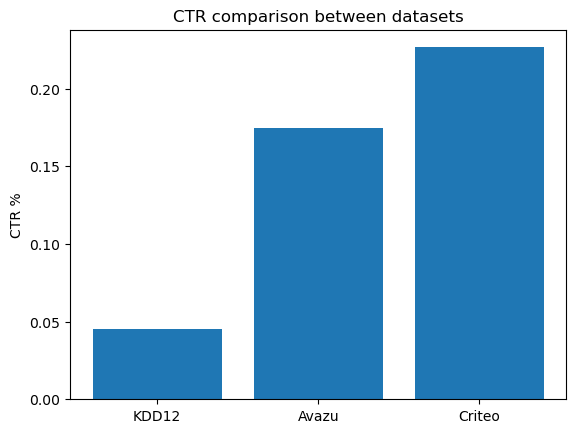

In [15]:
# Calculate Click-Through Rates for the three datasets
datasets = ['KDD12','Avazu','Criteo']
CTRs = [
    kdd12['Click'].sum()/kdd12['Impression'].sum(),
    avazu['click'].sum()/avazu.shape[0],
    criteo['click'].sum()/criteo.shape[0]
]

# Plot the CTRs as bar charts
plt.bar(datasets, CTRs)
plt.ylabel('CTR %')
plt.title('CTR comparison between datasets')
plt.show()

### Sparse Multi-Value Categorical Features

As already mentioned above, ad marketplace data often contains sparse categorical features, which make signal detection extremely difficult in shallow modelling frameworks. Below I show examples from each dataset

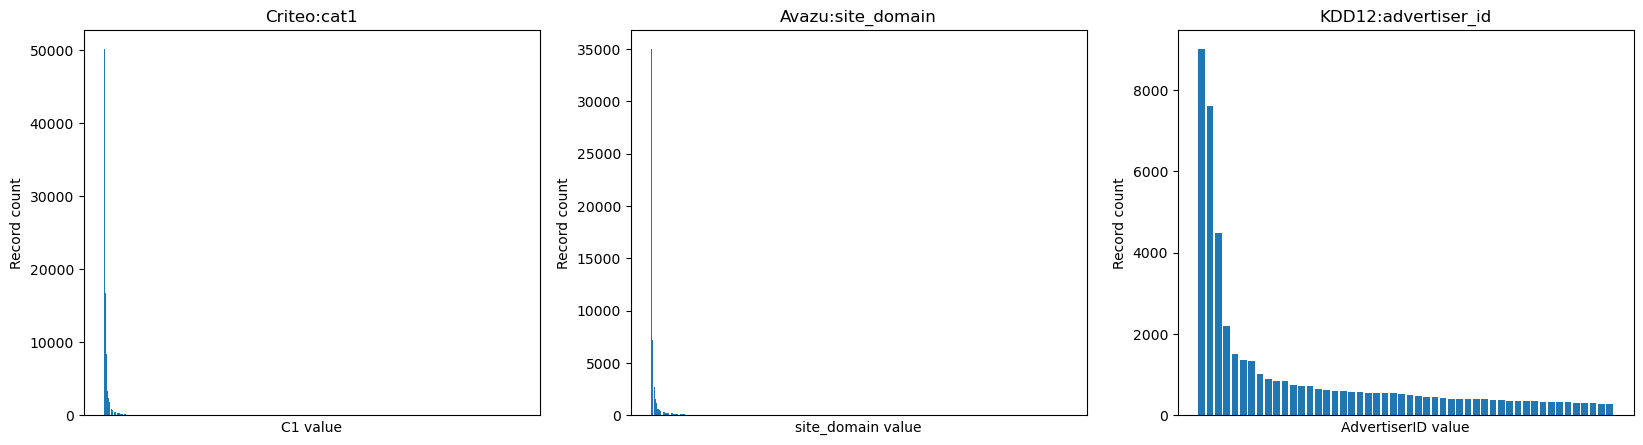

In [18]:
# Visualize record counts for Criteo:cat1, Avazu:site_domain, and KDD12:advertiser_id
criteo_cat1 = criteo.groupby('cat_1').agg({'click':'count'}).rename(columns={'click':'count'}).sort_values('count', ascending=False).reset_index()
avazu_site_domain = avazu.groupby('site_domain').agg({'click':'count'}).rename(columns={'click':'count'}).sort_values('count', ascending=False).reset_index()
kdd12_advertiser_id = kdd12.groupby('AdvertiserID').agg({'Click':'count'}).rename(columns={'Click':'count'}).sort_values('count', ascending=False).reset_index().astype({'AdvertiserID':str, 'count':int})

fig, axs = plt.subplots(1,3, figsize=(20,5))
axs[0].bar(criteo_cat1['cat_1'], criteo_cat1['count'])
axs[0].set_title('Criteo:cat1')
axs[0].set_ylabel('Record count')
axs[0].set_xlabel('C1 value')
axs[0].tick_params(axis='x',bottom=False,labelbottom=False) # Hide x-axis labels
axs[1].bar(avazu_site_domain['site_domain'], avazu_site_domain['count'])
axs[1].set_title('Avazu:site_domain')
axs[1].set_ylabel('Record count')
axs[1].set_xlabel('site_domain value')
axs[1].tick_params(axis='x',bottom=False,labelbottom=False) # Hide x-axis labels
axs[2].bar(kdd12_advertiser_id[:50]['AdvertiserID'], kdd12_advertiser_id[:50]['count'])
axs[2].set_title('KDD12:advertiser_id')
axs[2].set_ylabel('Record count')
axs[2].set_xlabel('AdvertiserID value')
axs[2].tick_params(axis='x',bottom=False,labelbottom=False) # Hide x-axis labels
plt.show()

A common remidy to the above issue is to _bin_ the categorical feature values before one-hot encoding or embedding, according to some given threshold (Cite Song, Others). This essentially means that for a given threshold $t$, we retain only the values for the multi-value categorical features that have more than $t$ occurances in the dataset. In the data pre-processing section, we implement this using thresholds 10, 5 and 10 for Criteo, KDD12 and Avazu respectively.

In [21]:
# Implement one-hot encoding for the categorical features in the three datasets
def one_hot_encode(df, columns, threshold=10):
    enc = OneHotEncoder(min_frequency=threshold)
    enc_df = pd.DataFrame(enc.fit_transform(df[columns]).toarray())
    enc_df.columns = enc.get_feature_names_out(columns)
    df = df.drop(columns=columns)
    df = pd.concat([df, enc_df], axis=1)
    return df

# One-hot encode the categorical features in the three datasets
kdd12_categorical_columns = [
    'DisplayURL',
    'AdID',
    'AdvertiserID',
    'QueryID',
    'KeywordID',
    'TitleID',
    'DescriptionID',
    'UserID'
]
kdd12_encoded = one_hot_encode(kdd12, kdd12_categorical_columns, threshold=50)

avazu_categorical_columns = [
    'id',
    'C1',
    'banner_pos',
    'site_id',
    'site_domain',
    'site_category',
    'app_id',
    'app_domain',
    'app_category',
    'device_id',
    'device_ip',
    'device_model',
    'device_type',
    'device_conn_type',
    'C14',
    'C15',
    'C16',
    'C17',
    'C18',
    'C19',
    'C20',
    'C21'
]
avazu_encoded = one_hot_encode(avazu, avazu_categorical_columns, threshold=100)

criteo_categorical_columns = [f'cat_{i}' for i in np.arange(1,27)]
criteo_encoded = one_hot_encode(criteo, criteo_categorical_columns, threshold=100)

In [26]:
# Print the shape of the original datasets
print("Before one-hot encoding:")
print(f"KDD12 shape: {kdd12.shape}")
print(f"Avazu shape: {avazu.shape}")
print(f"Criteo shape: {criteo.shape}\n")

# Print the resulting shapes of the datasets
print("After one-hot encoding:")
print(f"KDD12 shape: {kdd12_encoded.shape}")
print(f"Avazu shape: {avazu_encoded.shape}")
print(f"Criteo shape: {criteo_encoded.shape}")

Before one-hot encoding:
KDD12 shape: (100000, 12)
Avazu shape: (100000, 24)
Criteo shape: (100000, 40)

After one-hot encoding:
KDD12 shape: (100000, 1382)
Avazu shape: (100000, 639)
Criteo shape: (100000, 1849)


### Correlation Analysis

Below I conduct a correlation analysis of the features to the Click-Through rate

In [29]:
# Compute the correlation matrix for the three datasets
kdd12_corr = kdd12_encoded.corr()
avazu_corr = avazu_encoded.corr()
criteo_corr = criteo_encoded.corr()

In [ ]:
# Plot the correlation matrix for Avazu using seaborn
plt.figure(figsize=(15,15))
sns.heatmap(avazu_corr, cmap='coolwarm', center=0)
plt.title('Correlation matrix for Avazu dataset')
plt.show()

# Simulatinons

# Summary of findings

# Suggested Future Research

<a class="anchor" id="references"></a>

# References

<a class="anchor" id="eMarketer"></a>

- eMarketer. (2023). Digital advertising spending worldwide from 2021 to 2027 (in billion U.S. dollars) . Statista. Statista Inc.. Accessed: June 09, 2024. https://www-statista-com.iclibezp1.cc.ic.ac.uk/statistics/237974/online-advertising-spending-worldwide/

<a class="anchor" id="kdd12"></a>

- Aden, Yi Wang. (2012). KDD Cup 2012, Track 2. Kaggle. https://kaggle.com/competitions/kddcup2012-track2

<a class="anchor" id="avazu"></a>

- Steve Wang, Will Cukierski. (2014). Click-Through Rate Prediction. Kaggle. https://kaggle.com/competitions/avazu-ctr-prediction

<a class="anchor" id="criteo"></a>

- Jean-Baptiste Tien, joycenv, Olivier Chapelle. (2014). Display Advertising Challenge. Kaggle. https://kaggle.com/competitions/criteo-display-ad-challenge